In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math
from prettytable import PrettyTable
from scipy import sparse
import csv

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [2]:
pt = PrettyTable()
pt.field_names = ["Model", "Optimal Parameters", "Scoring Metric", "Score", "TPR", "TNR", "FPR", "FNR"]

In [3]:
def standardize_data(train, train_vectors, test, test_vectors, dense_matrix=False):
    sc = StandardScaler()
    
    y_train = train['Score']
    X_train = train.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Score', 'Summary', 'Text', 'CleanedText'], axis=1)
    X_train = sc.fit_transform(X_train)
    print(X_train.shape, train_vectors.shape)
    if dense_matrix:
        X_train = np.hstack((X_train, train_vectors))
    else:
        X_train = sparse.hstack((X_train, train_vectors))
    
    print('X_Train: {0}'.format(X_train.shape))
    print('y_Train: {0}'.format(y_train.shape))
    
    y_test = test['Score']
    X_test = test.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'Score', 'Summary', 'Text', 'CleanedText'], axis=1)
    X_test = sc.transform(X_test)
    if dense_matrix:
        X_test = np.hstack((X_test, test_vectors))
    else:
        X_test = sparse.hstack((X_test, test_vectors))
    
    print('X_Test: {0}'.format(X_test.shape))
    print('y_Test: {0}'.format(y_test.shape))
    
    return X_train, y_train, X_test, y_test

In [4]:
def plot_scores(optimal_model, param):
    _, = plt.plot(list(optimal_model.cv_results_[f'param_{param}']), \
                      list(optimal_model.cv_results_['mean_train_score']), 'g-', \
                     label='Training Scores')
    _, = plt.plot(list(optimal_model.cv_results_[f'param_{param}']), \
                      list(optimal_model.cv_results_['mean_test_score']), 'r-', \
                      label='Test Scores')
    _, = plt.plot(optimal_model.best_params_[param], optimal_model.best_score_, 'bo', \
            label=f"Optimal Value ({param}={optimal_model.best_params_[param]}, Score={round(optimal_model.best_score_,2)})")

    plt.xlabel(param)
    plt.ylabel('Scores')
    plt.legend()
    plt.show()

In [16]:
def run_SVC(train, train_vectors, test, test_vectors, kernel='linear', \
            metric='precision_macro', dense_matrix=False):
    '''
    Perform SVM Classification modelling on the I/P Train and Test data.
    1. Remove not required Columns, Standardize data and concatenate data with the text vectors.
    2. Perform Cross Validation and find Optimal parameters - 'C'.
    3. Use the Optimal parameters based model on the Training data and evaluate the Test data.
    4. Evaluate Performance of Model based on TPR, TNR, FPR, FNR.
    '''
    # Drop not required Columns, Standardize data and concatenate data with text vectors
    X_train, y_train, X_test, y_test = standardize_data(train, train_vectors, test, test_vectors, dense_matrix=dense_matrix)

    del train, train_vectors, test, test_vectors
    
    if kernel == 'linear':
        svc = LinearSVC(random_state=42)
        parameters = {'C':(0.0001, 0.001, 0.01, 0.1, 1.0)}
    else:
        svc = SVC(random_state=42, kernel='rbf')
        parameters = {'C':(0.01, 0.1, 1.0, 10.0),
                     'gamma':('auto', 'scale')}
    svc_optimal = GridSearchCV(svc, param_grid=parameters, cv=2, scoring=metric, verbose=0, refit=True)
    svc_optimal.fit(X_train, y_train)

    # Plot Train vs Test Scores and the Optimal Parameter
    plot_scores(svc_optimal, 'C')
    if kernel != 'linear':
        plot_scores(svc_optimal, 'gamma')

    # Confusion Matrix for Train Data
    pred = []
    for i in range(0, X_train.shape[0], 2000):
        if dense_matrix:
            test_batch = X_train[i:i+2000]
        else:
            test_batch = X_train.todok()[i:i+2000]
        pred.extend(svc_optimal.predict(test_batch))
    conf_matrix = confusion_matrix(y_train, pred)
    TPR = conf_matrix[1,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    TNR = conf_matrix[0,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FPR = conf_matrix[1,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FNR = conf_matrix[0,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    print('\nConfusion Matrix for Train Data :-')
    print(conf_matrix)
    print("\nTPR: {0} %\nTNR: {1} %\nFPR: {2} %\nFNR: {3} %\n".format(TPR*100, TNR*100, FPR*100, FNR*100))
    
    del X_train, y_train
    
    # Confusion Matrix for Test Data
    pred = []
    for i in range(0, X_test.shape[0], 2000):
        if dense_matrix:
            test_batch = X_test[i:i+2000]
        else:
            test_batch = X_test.todok()[i:i+2000]
        pred.extend(svc_optimal.predict(test_batch))

    ps = precision_score(y_test, pred, average='macro') * 100
    print(f'\nPrecision_Score of the Optimal SVM Classifier with parameters-{svc_optimal.best_params_} is {ps} %')
    
    conf_matrix = confusion_matrix(y_test, pred)
    TPR = conf_matrix[1,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    TNR = conf_matrix[0,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FPR = conf_matrix[1,0]/(conf_matrix[0,0] + conf_matrix[1,0])
    FNR = conf_matrix[0,1]/(conf_matrix[0,1] + conf_matrix[1,1])
    print('\nConfusion Matrix for Test Data :-')
    print(conf_matrix)
    print("\nTPR: {0} %\nTNR: {1} %\nFPR: {2} %\nFNR: {3} %\n".format(TPR*100, TNR*100, FPR*100, FNR*100))
    print('\nClassification Report :-\n')
    print(classification_report(y_test, pred))
    
    if kernel == 'linear':
        #  Plot Heatmap with Confusion Matrix
        print("\nHeatmap for Hyperparameter - 'C' with Scores as data :-")
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
    else:
        # Plot Heatmap for Hyperparameters - 'n_estimators' vs 'max_depth' with Scores as data
        cols = np.unique(svc_optimal.cv_results_['param_C'].data)
        indx = np.unique(svc_optimal.cv_results_['param_gamma'].data)
        data = svc_optimal.cv_results_['mean_test_score'].reshape(indx.shape[0], cols.shape[0])
        hyper_params = pd.DataFrame(data=data, columns=cols, index= indx)
        hyper_params.fillna(value=0.0, inplace=True)
        print("\nHeatmap for Hyperparameters - 'C' vs 'gamma' with Scores as data :-")
        sns.heatmap(hyper_params, annot=True, fmt='f', cmap='coolwarm')
    
    if kernel == 'linear':
        return [svc_optimal.best_params_, metric, round(ps,2), round(TPR*100,2), round(TNR*100,2), \
            round(FPR*100,2), round(FNR*100,2), svc_optimal.cv_results_, svc_optimal.best_estimator_.coef_[0]]
    else:
        return [svc_optimal.best_params_, metric, round(ps,2), round(TPR*100,2), round(TNR*100,2), \
            round(FPR*100,2), round(FNR*100,2), svc_optimal.cv_results_]

In [6]:
data_train = pd.read_csv('./Matrices/data_train.csv')
data_test = pd.read_csv('./Matrices/data_test.csv')

## Linear SVC for BOW Vectorizer

In [7]:
%%time
cv_model = CountVectorizer(max_features=10000, min_df=10)
bow_counts_train = cv_model.fit_transform(data_train['CleanedText'].values)
bow_counts_test = cv_model.transform(data_test['CleanedText'].values)
print(bow_counts_train.shape, bow_counts_test.shape)

(56000, 6604) (24000, 6604)
Wall time: 3.04 s


(56000, 4) (56000, 6604)
X_Train: (56000, 6608)
y_Train: (56000,)
X_Test: (24000, 6608)
y_Test: (24000,)


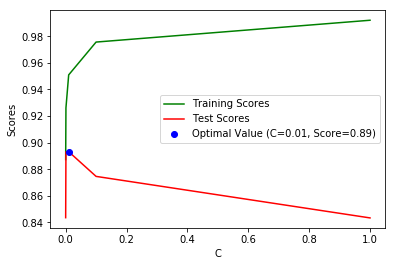


Confusion Matrix for Train Data :-
[[ 5799  1863]
 [  542 47796]]

TPR: 96.24841418473993 %
TNR: 91.45245229459076 %
FPR: 8.547547705409242 %
FNR: 3.7515858152600736 %


Precision_Score of the Optimal SVM Classifier with parameters-{'C': 0.01} is 90.44375659639383 %

Confusion Matrix for Test Data :-
[[ 2960  1139]
 [  465 19436]]

TPR: 94.46415552855407 %
TNR: 86.42335766423358 %
FPR: 13.576642335766422 %
FNR: 5.535844471445929 %


Classification Report :-

              precision    recall  f1-score   support

           0       0.86      0.72      0.79      4099
           1       0.94      0.98      0.96     19901

   micro avg       0.93      0.93      0.93     24000
   macro avg       0.90      0.85      0.87     24000
weighted avg       0.93      0.93      0.93     24000


Heatmap for Hyperparameter - 'C' with Scores as data :-
Wall time: 1min 20s


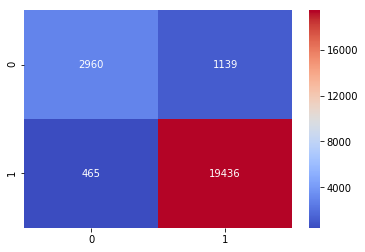

In [8]:
%%time
info = run_SVC(data_train, bow_counts_train, data_test, bow_counts_test)

In [9]:
%%time
n = 20; coeffs = info[-1]; coef_pt = PrettyTable();
coef_pt.field_names = ["Coeff_Neg", "Best Negative Features", "Coeff_Pos", "Best Positive Features"]
feature_names = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'TextLength'] \
                + cv_model.get_feature_names()
coefs_with_fns = sorted(zip(coeffs, feature_names))
top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    coef_pt.add_row([round(coef_1,3), fn_1, round(coef_2,3), fn_2])
print(coef_pt)

+-----------+------------------------+-----------+------------------------+
| Coeff_Neg | Best Negative Features | Coeff_Pos | Best Positive Features |
+-----------+------------------------+-----------+------------------------+
|   -1.132  | HelpfulnessDenominator |   1.072   |  HelpfulnessNumerator  |
|   -0.585  |         worst          |   0.424   |         delici         |
|   -0.473  |       disappoint       |   0.411   |         excel          |
|   -0.464  |        horribl         |   0.367   |        perfect         |
|   -0.455  |           aw           |   0.364   |         addict         |
|   -0.424  |        terribl         |   0.351   |          best          |
|   -0.422  |        unfortun        |   0.343   |         awesom         |
|   -0.351  |         threw          |   0.336   |         yummi          |
|   -0.346  |          poor          |   0.322   |          amaz          |
|   -0.338  |       tasteless        |   0.317   |        fantast         |
|   -0.335  

In [10]:
%%time
pt.add_row(['BOW (Linear)'] + info[:-2])
print(pt)

+--------------+--------------------+-----------------+-------+-------+-------+-------+------+
|    Model     | Optimal Parameters |  Scoring Metric | Score |  TPR  |  TNR  |  FPR  | FNR  |
+--------------+--------------------+-----------------+-------+-------+-------+-------+------+
| BOW (Linear) |    {'C': 0.01}     | precision_macro | 90.44 | 94.46 | 86.42 | 13.58 | 5.54 |
+--------------+--------------------+-----------------+-------+-------+-------+-------+------+
Wall time: 0 ns


## 'RBF' Kernel based SVC for BOW Vectorizer

In [11]:
%%time
cv_model = CountVectorizer(max_features=2000, min_df=10)
bow_counts_train = cv_model.fit_transform(data_train['CleanedText'].values)
bow_counts_test = cv_model.transform(data_test['CleanedText'].values)
print(bow_counts_train.shape, bow_counts_test.shape)

(56000, 2000) (24000, 2000)
Wall time: 2.81 s


(56000, 4) (56000, 2000)
X_Train: (56000, 2004)
y_Train: (56000,)
X_Test: (24000, 2004)
y_Test: (24000,)


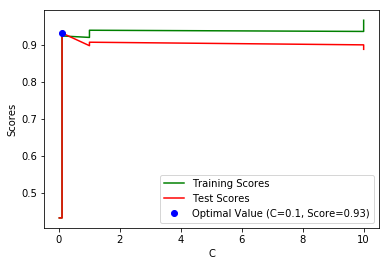

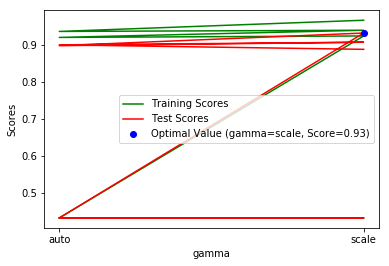


Confusion Matrix for Train Data :-
[[  552  7110]
 [   11 48327]]

TPR: 87.17463066183235 %
TNR: 98.04618117229128 %
FPR: 1.9538188277087036 %
FNR: 12.82536933816765 %


Precision_Score of the Optimal SVM Classifier with parameters-{'C': 0.1, 'gamma': 'scale'} is 90.39703328020478 %

Confusion Matrix for Test Data :-
[[  257  3842]
 [    8 19893]]

TPR: 83.81293448493786 %
TNR: 96.98113207547169 %
FPR: 3.018867924528302 %
FNR: 16.187065515062145 %


Classification Report :-

              precision    recall  f1-score   support

           0       0.97      0.06      0.12      4099
           1       0.84      1.00      0.91     19901

   micro avg       0.84      0.84      0.84     24000
   macro avg       0.90      0.53      0.51     24000
weighted avg       0.86      0.84      0.78     24000


Heatmap for Hyperparameters - 'C' vs 'gamma' with Scores as data :-
Wall time: 1h 14min


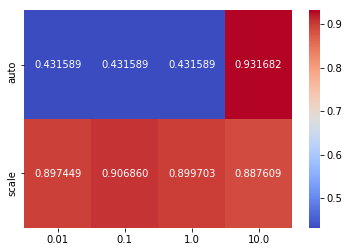

In [12]:
%%time
info = run_SVC(data_train, bow_counts_train, data_test, bow_counts_test, kernel='rbf')

In [13]:
%%time
pt.add_row(['BOW (RBF)'] + info[:-1])
print(pt)

+--------------+------------------------------+-----------------+-------+-------+-------+-------+-------+
|    Model     |      Optimal Parameters      |  Scoring Metric | Score |  TPR  |  TNR  |  FPR  |  FNR  |
+--------------+------------------------------+-----------------+-------+-------+-------+-------+-------+
| BOW (Linear) |         {'C': 0.01}          | precision_macro | 90.44 | 94.46 | 86.42 | 13.58 |  5.54 |
|  BOW (RBF)   | {'C': 0.1, 'gamma': 'scale'} | precision_macro |  90.4 | 83.81 | 96.98 |  3.02 | 16.19 |
+--------------+------------------------------+-----------------+-------+-------+-------+-------+-------+
Wall time: 0 ns


In [17]:
del cv_model, bow_counts_train, bow_counts_test

## Linear SVC for TFIDF Vectorizer

In [18]:
%%time
tfidf_model = TfidfVectorizer(max_features=10000, min_df=10)
tfidf_train = tfidf_model.fit_transform(data_train['CleanedText'].values)
tfidf_test = tfidf_model.transform(data_test['CleanedText'].values)
print(tfidf_train.shape, tfidf_test.shape)

(56000, 6604) (24000, 6604)
Wall time: 3.27 s


(56000, 4) (56000, 6604)
X_Train: (56000, 6608)
y_Train: (56000,)
X_Test: (24000, 6608)
y_Test: (24000,)


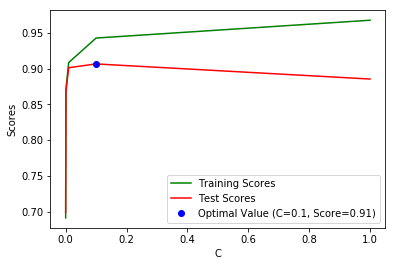


Confusion Matrix for Train Data :-
[[ 5441  2221]
 [  508 47830]]

TPR: 95.56252622325229 %
TNR: 91.46074970583291 %
FPR: 8.539250294167088 %
FNR: 4.4374737767477175 %


Precision_Score of the Optimal SVM Classifier with parameters-{'C': 0.1} is 91.4967484636352 %

Confusion Matrix for Test Data :-
[[ 2788  1311]
 [  335 19566]]

TPR: 93.7203621209944 %
TNR: 89.27313480627602 %
FPR: 10.726865193723983 %
FNR: 6.279637879005604 %


Classification Report :-

              precision    recall  f1-score   support

           0       0.89      0.68      0.77      4099
           1       0.94      0.98      0.96     19901

   micro avg       0.93      0.93      0.93     24000
   macro avg       0.91      0.83      0.87     24000
weighted avg       0.93      0.93      0.93     24000


Heatmap for Hyperparameter - 'C' with Scores as data :-
Wall time: 1min 44s


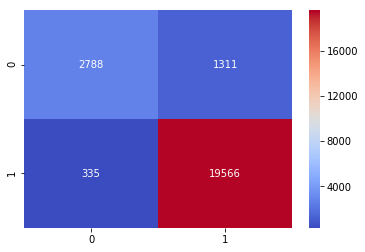

In [19]:
%%time
info = run_SVC(data_train, tfidf_train, data_test, tfidf_test)

In [20]:
%%time
n = 20; coeffs = info[-1]; coef_pt = PrettyTable();
coef_pt.field_names = ["Coeff_Neg", "Best Negative Features", "Coeff_Pos", "Best Positive Features"]
feature_names = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'TextLength'] \
                + tfidf_model.get_feature_names()
coefs_with_fns = sorted(zip(coeffs, feature_names))
top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    coef_pt.add_row([round(coef_1,3), fn_1, round(coef_2,3), fn_2])
print(coef_pt)

+-----------+------------------------+-----------+------------------------+
| Coeff_Neg | Best Negative Features | Coeff_Pos | Best Positive Features |
+-----------+------------------------+-----------+------------------------+
|   -2.587  |       disappoint       |   3.128   |         great          |
|   -2.374  |         worst          |   2.694   |          best          |
|   -2.231  |          not           |   2.397   |         delici         |
|   -1.96   |        horribl         |   2.177   |          love          |
|   -1.847  |        terribl         |   2.086   |         excel          |
|   -1.809  |           aw           |   1.952   |          good          |
|   -1.721  |        unfortun        |   1.945   |        perfect         |
|   -1.48   |          wast          |   1.619   |          nice          |
|   -1.419  |          poor          |   1.427   |         wonder         |
|   -1.36   |        disgust         |   1.399   |          amaz          |
|   -1.337  

In [21]:
%%time
pt.add_row(['TFIDF (Linear)'] + info[:-2])
print(pt)

+----------------+------------------------------+-----------------+-------+-------+-------+-------+-------+
|     Model      |      Optimal Parameters      |  Scoring Metric | Score |  TPR  |  TNR  |  FPR  |  FNR  |
+----------------+------------------------------+-----------------+-------+-------+-------+-------+-------+
|  BOW (Linear)  |         {'C': 0.01}          | precision_macro | 90.44 | 94.46 | 86.42 | 13.58 |  5.54 |
|   BOW (RBF)    | {'C': 0.1, 'gamma': 'scale'} | precision_macro |  90.4 | 83.81 | 96.98 |  3.02 | 16.19 |
| TFIDF (Linear) |          {'C': 0.1}          | precision_macro |  91.5 | 93.72 | 89.27 | 10.73 |  6.28 |
+----------------+------------------------------+-----------------+-------+-------+-------+-------+-------+
Wall time: 1.03 ms


## 'RBF' Kernel based SVC for TFIDF Vectorizer

In [22]:
%%time
tfidf_model = TfidfVectorizer(max_features=2000, min_df=10)
tfidf_train = tfidf_model.fit_transform(data_train['CleanedText'].values)
tfidf_test = tfidf_model.transform(data_test['CleanedText'].values)
print(tfidf_train.shape, tfidf_test.shape)

(56000, 2000) (24000, 2000)
Wall time: 3.29 s


(56000, 4) (56000, 2000)
X_Train: (56000, 2004)
y_Train: (56000,)
X_Test: (24000, 2004)
y_Test: (24000,)


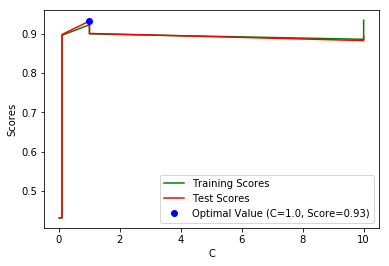

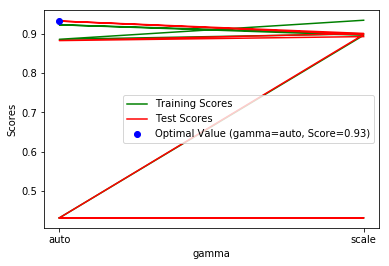


Confusion Matrix for Train Data :-
[[   97  7565]
 [   11 48327]]

TPR: 86.46496815286623 %
TNR: 89.81481481481481 %
FPR: 10.185185185185185 %
FNR: 13.535031847133757 %


Precision_Score of the Optimal SVM Classifier with parameters-{'C': 1.0, 'gamma': 'auto'} is 85.23390593729152 %

Confusion Matrix for Test Data :-
[[   14  4085]
 [    2 19899]]

TPR: 82.96781187458305 %
TNR: 87.5 %
FPR: 12.5 %
FNR: 17.032188125416944 %


Classification Report :-

              precision    recall  f1-score   support

           0       0.88      0.00      0.01      4099
           1       0.83      1.00      0.91     19901

   micro avg       0.83      0.83      0.83     24000
   macro avg       0.85      0.50      0.46     24000
weighted avg       0.84      0.83      0.75     24000


Heatmap for Hyperparameters - 'C' vs 'gamma' with Scores as data :-
Wall time: 1h 21min 27s


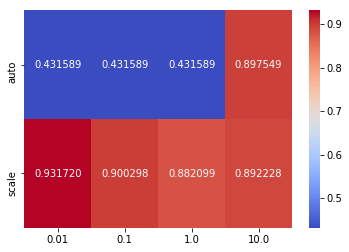

In [23]:
%%time
info = run_SVC(data_train, tfidf_train, data_test, tfidf_test, kernel='rbf')

In [24]:
%%time
pt.add_row(['TFIDF (RBF)'] + info[:-1])
print(pt)

+----------------+------------------------------+-----------------+-------+-------+-------+-------+-------+
|     Model      |      Optimal Parameters      |  Scoring Metric | Score |  TPR  |  TNR  |  FPR  |  FNR  |
+----------------+------------------------------+-----------------+-------+-------+-------+-------+-------+
|  BOW (Linear)  |         {'C': 0.01}          | precision_macro | 90.44 | 94.46 | 86.42 | 13.58 |  5.54 |
|   BOW (RBF)    | {'C': 0.1, 'gamma': 'scale'} | precision_macro |  90.4 | 83.81 | 96.98 |  3.02 | 16.19 |
| TFIDF (Linear) |          {'C': 0.1}          | precision_macro |  91.5 | 93.72 | 89.27 | 10.73 |  6.28 |
|  TFIDF (RBF)   | {'C': 1.0, 'gamma': 'auto'}  | precision_macro | 85.23 | 82.97 |  87.5 |  12.5 | 17.03 |
+----------------+------------------------------+-----------------+-------+-------+-------+-------+-------+
Wall time: 997 µs


In [25]:
del tfidf_model, tfidf_train, tfidf_test

## Linear SVC for Avg. W2V Vectorizer

In [26]:
%%time
sent_vectors_train = pd.read_csv('./Matrices/avg_w2v_train.csv')
sent_vectors_test = pd.read_csv('./Matrices/avg_w2v_test.csv')

Wall time: 1.74 s


(56000, 4) (56000, 50)
X_Train: (56000, 54)
y_Train: (56000,)
X_Test: (24000, 54)
y_Test: (24000,)


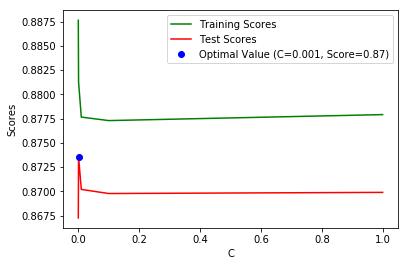


Confusion Matrix for Train Data :-
[[ 3756  3906]
 [  784 47554]]

TPR: 92.40963855421687 %
TNR: 82.73127753303964 %
FPR: 17.26872246696035 %
FNR: 7.590361445783132 %


Precision_Score of the Optimal SVM Classifier with parameters-{'C': 0.001} is 87.39555362412565 %

Confusion Matrix for Test Data :-
[[ 2063  2036]
 [  386 19515]]

TPR: 90.5526425687903 %
TNR: 84.238464679461 %
FPR: 15.761535320538997 %
FNR: 9.447357431209689 %


Classification Report :-

              precision    recall  f1-score   support

           0       0.84      0.50      0.63      4099
           1       0.91      0.98      0.94     19901

   micro avg       0.90      0.90      0.90     24000
   macro avg       0.87      0.74      0.79     24000
weighted avg       0.89      0.90      0.89     24000


Heatmap for Hyperparameter - 'C' with Scores as data :-
Wall time: 22.7 s


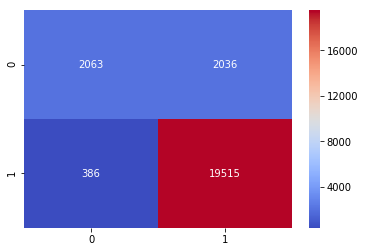

In [27]:
%%time
info = run_SVC(data_train, sent_vectors_train, data_test, sent_vectors_test, dense_matrix=True)

In [28]:
%%time
pt.add_row(['Avg. W2V (Linear)'] + info[:-2])
print(pt)

+-------------------+------------------------------+-----------------+-------+-------+-------+-------+-------+
|       Model       |      Optimal Parameters      |  Scoring Metric | Score |  TPR  |  TNR  |  FPR  |  FNR  |
+-------------------+------------------------------+-----------------+-------+-------+-------+-------+-------+
|    BOW (Linear)   |         {'C': 0.01}          | precision_macro | 90.44 | 94.46 | 86.42 | 13.58 |  5.54 |
|     BOW (RBF)     | {'C': 0.1, 'gamma': 'scale'} | precision_macro |  90.4 | 83.81 | 96.98 |  3.02 | 16.19 |
|   TFIDF (Linear)  |          {'C': 0.1}          | precision_macro |  91.5 | 93.72 | 89.27 | 10.73 |  6.28 |
|    TFIDF (RBF)    | {'C': 1.0, 'gamma': 'auto'}  | precision_macro | 85.23 | 82.97 |  87.5 |  12.5 | 17.03 |
| Avg. W2V (Linear) |         {'C': 0.001}         | precision_macro |  87.4 | 90.55 | 84.24 | 15.76 |  9.45 |
+-------------------+------------------------------+-----------------+-------+-------+-------+-------+-------+
W

## 'RBF' Kernel based SVC for Avg. W2V Vectorizer

(56000, 4) (56000, 50)
X_Train: (56000, 54)
y_Train: (56000,)
X_Test: (24000, 54)
y_Test: (24000,)


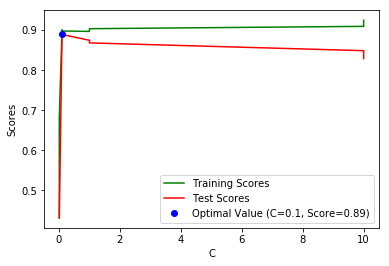

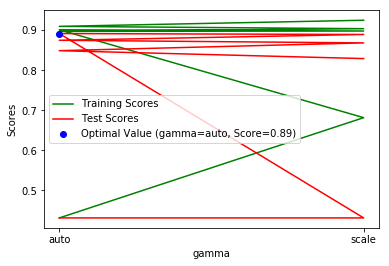


Confusion Matrix for Train Data :-
[[ 3535  4127]
 [  570 47768]]

TPR: 92.04740341073321 %
TNR: 86.11449451887941 %
FPR: 13.885505481120585 %
FNR: 7.952596589266789 %


Precision_Score of the Optimal SVM Classifier with parameters-{'C': 0.1, 'gamma': 'auto'} is 88.70317388112112 %

Confusion Matrix for Test Data :-
[[ 1929  2170]
 [  279 19622]]

TPR: 90.04221732745961 %
TNR: 87.36413043478261 %
FPR: 12.635869565217392 %
FNR: 9.95778267254038 %


Classification Report :-

              precision    recall  f1-score   support

           0       0.87      0.47      0.61      4099
           1       0.90      0.99      0.94     19901

   micro avg       0.90      0.90      0.90     24000
   macro avg       0.89      0.73      0.78     24000
weighted avg       0.90      0.90      0.88     24000


Heatmap for Hyperparameters - 'C' vs 'gamma' with Scores as data :-
Wall time: 16min 54s


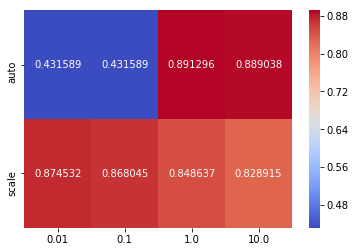

In [29]:
%%time
info = run_SVC(data_train, sent_vectors_train, data_test, sent_vectors_test, dense_matrix=True, kernel='rbf')

In [30]:
%%time
pt.add_row(['Avg. W2V (RBF)'] + info[:-1])
print(pt)

+-------------------+------------------------------+-----------------+-------+-------+-------+-------+-------+
|       Model       |      Optimal Parameters      |  Scoring Metric | Score |  TPR  |  TNR  |  FPR  |  FNR  |
+-------------------+------------------------------+-----------------+-------+-------+-------+-------+-------+
|    BOW (Linear)   |         {'C': 0.01}          | precision_macro | 90.44 | 94.46 | 86.42 | 13.58 |  5.54 |
|     BOW (RBF)     | {'C': 0.1, 'gamma': 'scale'} | precision_macro |  90.4 | 83.81 | 96.98 |  3.02 | 16.19 |
|   TFIDF (Linear)  |          {'C': 0.1}          | precision_macro |  91.5 | 93.72 | 89.27 | 10.73 |  6.28 |
|    TFIDF (RBF)    | {'C': 1.0, 'gamma': 'auto'}  | precision_macro | 85.23 | 82.97 |  87.5 |  12.5 | 17.03 |
| Avg. W2V (Linear) |         {'C': 0.001}         | precision_macro |  87.4 | 90.55 | 84.24 | 15.76 |  9.45 |
|   Avg. W2V (RBF)  | {'C': 0.1, 'gamma': 'auto'}  | precision_macro |  88.7 | 90.04 | 87.36 | 12.64 |  9.96 |
+

## Linear SVC for TFIDF-weighted W2V Vectorizer

In [31]:
%%time
sent_vectors_train = pd.read_csv('./Matrices/tfidf_w2v_train.csv')
sent_vectors_test = pd.read_csv('./Matrices/tfidf_w2v_test.csv')

Wall time: 1.8 s


(56000, 4) (56000, 50)
X_Train: (56000, 54)
y_Train: (56000,)
X_Test: (24000, 54)
y_Test: (24000,)


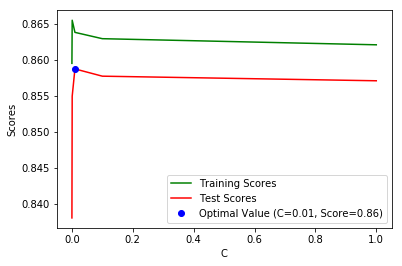


Confusion Matrix for Train Data :-
[[ 3582  4080]
 [  887 47451]]

TPR: 92.08243581533446 %
TNR: 80.15215931975833 %
FPR: 19.847840680241667 %
FNR: 7.917564184665542 %


Precision_Score of the Optimal SVM Classifier with parameters-{'C': 0.01} is 85.9389362034257 %

Confusion Matrix for Test Data :-
[[ 1865  2234]
 [  405 19496]]

TPR: 89.71928209848137 %
TNR: 82.15859030837004 %
FPR: 17.841409691629956 %
FNR: 10.280717901518639 %


Classification Report :-

              precision    recall  f1-score   support

           0       0.82      0.45      0.59      4099
           1       0.90      0.98      0.94     19901

   micro avg       0.89      0.89      0.89     24000
   macro avg       0.86      0.72      0.76     24000
weighted avg       0.88      0.89      0.88     24000


Heatmap for Hyperparameter - 'C' with Scores as data :-
Wall time: 31.8 s


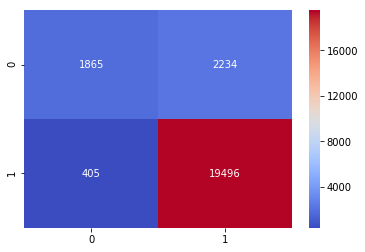

In [32]:
%%time
info = run_SVC(data_train, sent_vectors_train, data_test, sent_vectors_test, dense_matrix=True)

In [33]:
%%time
pt.add_row(['TFIDF W2V (Linear)'] + info[:-2])
print(pt)

+--------------------+------------------------------+-----------------+-------+-------+-------+-------+-------+
|       Model        |      Optimal Parameters      |  Scoring Metric | Score |  TPR  |  TNR  |  FPR  |  FNR  |
+--------------------+------------------------------+-----------------+-------+-------+-------+-------+-------+
|    BOW (Linear)    |         {'C': 0.01}          | precision_macro | 90.44 | 94.46 | 86.42 | 13.58 |  5.54 |
|     BOW (RBF)      | {'C': 0.1, 'gamma': 'scale'} | precision_macro |  90.4 | 83.81 | 96.98 |  3.02 | 16.19 |
|   TFIDF (Linear)   |          {'C': 0.1}          | precision_macro |  91.5 | 93.72 | 89.27 | 10.73 |  6.28 |
|    TFIDF (RBF)     | {'C': 1.0, 'gamma': 'auto'}  | precision_macro | 85.23 | 82.97 |  87.5 |  12.5 | 17.03 |
| Avg. W2V (Linear)  |         {'C': 0.001}         | precision_macro |  87.4 | 90.55 | 84.24 | 15.76 |  9.45 |
|   Avg. W2V (RBF)   | {'C': 0.1, 'gamma': 'auto'}  | precision_macro |  88.7 | 90.04 | 87.36 | 12.64 | 

## 'RBF' Kernel based SVC for TFIDF-weighted W2V Vectorizer

(56000, 4) (56000, 50)
X_Train: (56000, 54)
y_Train: (56000,)
X_Test: (24000, 54)
y_Test: (24000,)


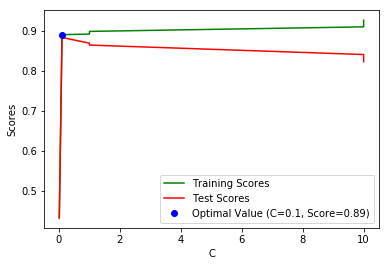

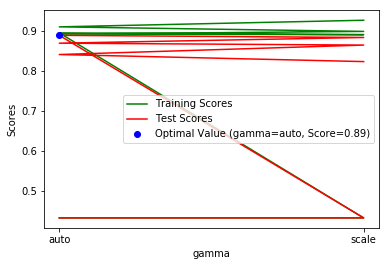


Confusion Matrix for Train Data :-
[[ 2714  4948]
 [  423 47915]]

TPR: 90.63995611297126 %
TNR: 86.51577940707682 %
FPR: 13.484220592923174 %
FNR: 9.360043887028734 %


Precision_Score of the Optimal SVM Classifier with parameters-{'C': 0.1, 'gamma': 'auto'} is 87.6256223145763 %

Confusion Matrix for Test Data :-
[[ 1411  2688]
 [  206 19695]]

TPR: 87.99088594022248 %
TNR: 87.26035868893011 %
FPR: 12.739641311069882 %
FNR: 12.00911405977751 %


Classification Report :-

              precision    recall  f1-score   support

           0       0.87      0.34      0.49      4099
           1       0.88      0.99      0.93     19901

   micro avg       0.88      0.88      0.88     24000
   macro avg       0.88      0.67      0.71     24000
weighted avg       0.88      0.88      0.86     24000


Heatmap for Hyperparameters - 'C' vs 'gamma' with Scores as data :-
Wall time: 18min 34s


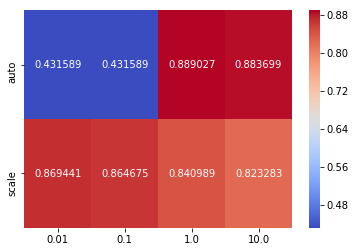

In [34]:
%%time
info = run_SVC(data_train, sent_vectors_train, data_test, sent_vectors_test, dense_matrix=True, kernel='rbf')

In [35]:
%%time
pt.add_row(['TFIDF W2V (RBF)'] + info[:-1])

Wall time: 0 ns


In [36]:
print(pt.get_string(sortby='Model'))

+--------------------+------------------------------+-----------------+-------+-------+-------+-------+-------+
|       Model        |      Optimal Parameters      |  Scoring Metric | Score |  TPR  |  TNR  |  FPR  |  FNR  |
+--------------------+------------------------------+-----------------+-------+-------+-------+-------+-------+
| Avg. W2V (Linear)  |         {'C': 0.001}         | precision_macro |  87.4 | 90.55 | 84.24 | 15.76 |  9.45 |
|   Avg. W2V (RBF)   | {'C': 0.1, 'gamma': 'auto'}  | precision_macro |  88.7 | 90.04 | 87.36 | 12.64 |  9.96 |
|    BOW (Linear)    |         {'C': 0.01}          | precision_macro | 90.44 | 94.46 | 86.42 | 13.58 |  5.54 |
|     BOW (RBF)      | {'C': 0.1, 'gamma': 'scale'} | precision_macro |  90.4 | 83.81 | 96.98 |  3.02 | 16.19 |
|   TFIDF (Linear)   |          {'C': 0.1}          | precision_macro |  91.5 | 93.72 | 89.27 | 10.73 |  6.28 |
|    TFIDF (RBF)     | {'C': 1.0, 'gamma': 'auto'}  | precision_macro | 85.23 | 82.97 |  87.5 |  12.5 | 

# Conclusions :-
-  The Dataset being highly imbalanced (8:1) the Scoring metric has been selected based on the Model performance of - high TPR & TNR and low FPR & FNR.
-  Based on the above performance criteria, both 'recall' and 'precision_macro' have shown to provide high True Negative Rate (TNR) or low False Positive Rate (FPR). 'precision_macro' metric has been used here to evaluate the models. 
-  From the Performances obtained on the four Vectorizer models, it has been observed that BOW Vectorizer based RBF Kernel SVC model is giving the best True Negative Rate (TNR) while TFIDF based Linear SVC model is giving the best overall performance - high TPR with a high TNR.
-  The Model performance might improve if the unbalancedness of the dataset can be treated with Oversampling - repeating Minority class or creating Synthetic datapoints using SMOTE.
-  Reducing the 'n_components' in the Vectorizer models has proved to increase the True Negative Rate.